# Réseaux de neurones pour la reconnaissance de chiffres manuscrits

Dans ce notebook, nous allons voir, étape par étape, comment entrainer un model pour reconnaitre des chiffres manuscrits. Pour cela nous devons :

1. importer les bibliothèques nécessaires, en particulier la bibliothèque keras 
2. charger les données, il s'agit du dataset mnist
3. définir notre réseau de neurones
4. entrainer le modèle
5. Le tester

Comme vous pouvez le remarquer, les étapes sont quasiment les mêmes que celles vues dans le cours sur le machine learning et la bibliothèque sklearn. Ce qui change c'est l'utilisation des réseaux de neurones.


Commençons donc par importer les bibliothèques nécessaires :

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Puis nous allons charger les données du dataset.

In [2]:
from keras.datasets import mnist

 Les concepteurs de mnist ont bien fait les choses : ils ont prévu une méthode permettant de découper les données en train et test.

In [21]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

On peut commencer par quelques manipulations de base pour explorer les données qu'on vient de charger :

In [4]:
print('X_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)

X_train shape:  (60000, 28, 28)
Y_train shape:  (60000,)


On voit que X_train contient 60k d'exemples. Cheque exemple est une image 28 x 28. Y_train contient 60k  étiquettes. On peut le voir en faisant comme suit :

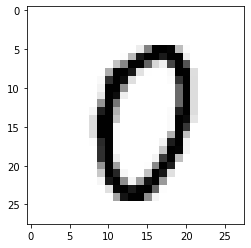

0


In [16]:
from matplotlib import pyplot as plt
from matplotlib import cm as cm

plt.imshow(X_train[1000], cmap=cm.Greys)
plt.show()

print(Y_train[1000])

Maintenant que nous avons vu à quoi ressemble notre dataset, on peut commencer à utiliser les réseaux de neurones pour reconnaître les chiffres manuscrits. 

Pour le moment, nous avons vu les réseaux de neurones "simples" et pas d'architectures avancées. Nous allons donc devoir "applatir" les données en entrée de notre réseau. En effet, les données arrivent sous forme d'images 28 x 28. Nous allons donc transformer chaque image en un vecteur de taille 28 x 28 = 784 :

In [6]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).T
X_test = X_test.reshape(X_test.shape[0], num_pixels).T
Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

Patience encore, nous allons faire quelques transformations supplémetaires sur les données pour changer le type de donnéese et les normer :

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')
X_train  = X_train / 255
X_test  = X_test / 255

Dans un but purement pédagogique, nous allons dans un premier temps faire une classification binaire : les chiffres correspondant à 5 seront labélisés 1 et ceux différents de 5 seront lablisés 0. Encore une fois c'est dans un but purement pédagogique ... 

In [8]:
Y_new = np.zeros(Y_train.shape)
Y_new[np.where(Y_train==5.0)[0]] = 1
Y_train = Y_new

Y_new = np.zeros(Y_test.shape)
Y_new[np.where(Y_test==5.0)[0]] = 1
Y_test = Y_new


Y_train = Y_train.T
Y_test = Y_test.T

Une dernière manipulation pour mélanger les données :

In [9]:
m = m = X_train.shape[1] #number of examples
np.random.seed(138)
shuffle_index = np.random.permutation(m)
X_train, Y_train = X_train[:,shuffle_index], Y_train[:,shuffle_index]

Commençons par essayer d'entrainer un model sans utiliser keras mais juste avec numpy. Pour cela, nous avons besoin de définir nos propres fonctions :

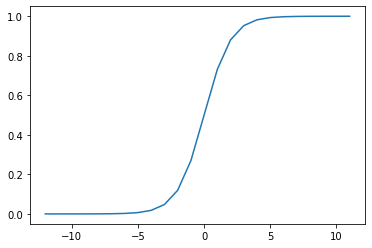

In [10]:
#On définit la fonction sigmoid :
def sigmoid(z):
    s = 1. / (1. + np.exp(-z))
    return s

#On peut visualiser ce qu'elle fait :
x = np.arange(-12.0, 12.0, 1.0, dtype=np.float32)
y = sigmoid(x)
plt.plot(x, y)
plt.show()

In [11]:
#On définit la fonction de "loss" :
def compute_loss(Y, Y_hat):
    m = Y.shape[1]
    L = -(1./m) * (np.sum(np.multiply(np.log(Y_hat),Y)) + np.sum( np.multiply(np.log(1-Y_hat),(1-Y))))
    return L

Nous y voilà, nous allons pouvoir définir la rétro propagation, construire et entrainer le modèle : 

In [12]:
learning_rate = 1.

X = X_train
Y = Y_train

print('Y.shape={}'.format(Y.shape))

n_x = X.shape[0]
m = X.shape[1]

W = np.random.randn(1, n_x) * 0.01
b = np.zeros((1, 1))

costs_list = []
for i in range(100):
    Z = np.matmul(W, X) + b
    A = sigmoid(Z)

    cost = compute_loss(Y, A)

    #print('A-Y.shape={}'.format((A-Y).shape))
    #print('X.T.shape={}'.format((X.T).shape))

    dW = (1./m) * np.matmul((A-Y), X.T)
    db = (1./m) * np.sum(A-Y, axis=1, keepdims=True)

    W = W - learning_rate * dW
    b = b - learning_rate * db

    if (i % 20 == 0):
        print("Epoch", i, "cost: ", cost)
        costs_list.append(cost)

print("Final cost:", cost)


Y.shape=(1, 60000)
Epoch 0 cost:  0.6817831288870175
Epoch 20 cost:  0.15693060630580025


KeyboardInterrupt: 

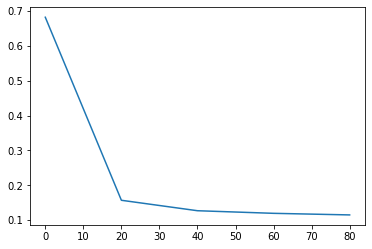

In [ ]:
x_axis = [i for i in range(0, 100, 20) ]
y_axis = costs_list
plt.plot(x_axis, y_axis)
plt.show()

## Réseaux de neurones avec keras

Ca reste compliqué de tout faire avec numpy ... Heureusement, il y a keras. 

Voici le code qui fait exactement la même chose que ce que nous avions fait avant :

In [ ]:
from __future__ import print_function

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop


#print('tensorflow:', tf.__version__)
#print('keras:', keras.__version__)


#load (first download if necessary) the MNIST dataset
# (the dataset is stored in your home direcoty in ~/.keras/datasets/mnist.npz
#  and will take  ~11MB)
# data is already split in train and test datasets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train : 60000 images of size 28x28, i.e., x_train.shape = (60000, 28, 28)
# y_train : 60000 labels (from 0 to 9)
# x_test  : 10000 images of size 28x28, i.e., x_test.shape = (10000, 28, 28)
# x_test  : 10000 labels
# all datasets are of type uint8

#To input our values in our network Dense layer, we need to flatten the datasets, i.e.,
# pass from (60000, 28, 28) to (60000, 784)
#flatten images
num_pixels = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], num_pixels)
x_test = x_test.reshape(x_test.shape[0], num_pixels)

#Convert to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalize inputs from [0; 255] to [0; 1]
x_train = x_train / 255
x_test = x_test / 255


#Convert class vectors to binary class matrices ("one hot encoding")
## Doc : https://keras.io/utils/#to_categorical
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)


num_classes = y_train.shape[1]



#Let start our work: creating a neural network

#####TO COMPLETE
def neural_network():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(.5))
    model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = neural_network()
model.summary()
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=25, batch_size=100)#98.36%

scores = model.evaluate(x_test, y_test)
print("Neural network accuracy: %.2f%%" % (scores[1]*100))



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 3s 57us/step - loss: 0.2307 - accuracy: 0.9339 - val_loss: 0.1110 - val_accuracy: 0.9663
Epoch 2/25
60000/60000 [==============================] - 3s 51us/step - loss: 0.0886 - accuracy: 0.9738 - val_loss: 0.0805 - val_accuracy: 0.9738
Epoch 3/25
60000/60000 [==============================] - 3s 52us/step - loss: 0.0561 - accuracy: 0.9834 - val_loss: 0.0692 - val_accuracy: 0.9784
Epoch 4/25
60000/60